# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

In [ ]:
from torch.utils.data import DataLoader
import os
from urllib import request
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from __future__ import print_function, division


import time

import copy

In [ ]:
mkdir ./data

In [ ]:
cd ./data

/content/data


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2022-02-16 07:52:57--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.198.44, 99.84.198.104, 99.84.198.88, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.198.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  83.9MB/s    in 0.5s    

2022-02-16 07:52:58 (83.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip 

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
cd ..

/content


In [ ]:
transforming_img_train = transforms.Compose([
    transforms.Resize((32,32)),   #CIFAR are 32*32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5],   #Normalization helps get data within a range and reduces the skewness which helps learn faster and better
                        [0.5,0.5,0.5])
])

transforming_img_test= transforms.Compose([
    transforms.Resize((32,32)),  
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [ ]:
train_path = ('/content/data/hymenoptera_data/train')
test_path = ('/content/data/hymenoptera_data/val')

train_loader= DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transforming_img_train),
    batch_size=4, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transforming_img_test),
    batch_size=4, shuffle=True
)


#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(f'The classes are: {classes}')

The classes are: ['ants', 'bees']


In [ ]:
num_classes = 2

**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

#### Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


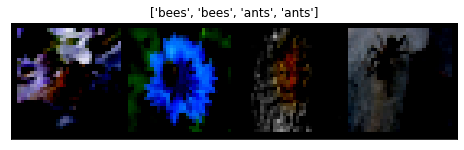

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(img,title=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()
    
    
    

hyp_train_iter = iter(train_loader)
images, labels = next(hyp_train_iter)
show_images(torchvision.utils.make_grid(images),title=[classes[x] for x in labels])

In [ ]:
print(labels)

tensor([0, 1, 1, 0])


## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [ ]:
import torch.nn.functional as F

# Inherit from LightningModule is you use pytorch-lightning, and you'll need to code some more methods
class ConvNet(nn.Module):

    def __init__(self, output_dim):

        super(ConvNet, self).__init__()
        #input_shape = (batch_size,depth,h,w)=(4,3,32,32)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1), #output_shape(4,12,32,32)
                                     
            nn.BatchNorm2d(12), #(4,12,32,32)
            nn.ReLU(inplace=True),#(4,12,32,32)
            nn.Conv2d(in_channels=12, out_channels= 32, kernel_size=3, stride=1, padding=1), #output_shape (4,32,32,32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), #(4,32,16,16)
            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=3, padding=1),#(4,64,16,16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2) #(4,64,8,8)
               
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 120),
            nn.Dropout(p = 0.5),
            nn.Linear(120, 2) ## We have only 2 classes 
                    
        )

        

    def forward(self, x):
        x=self.encoder(x)
        x=x.view(x.size(0),-1) 
        x=self.classifier(x)
        return x

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [ ]:
#check that the forward pass work 

In [ ]:
model = ConvNet(2)
#Optmizer and loss function
optimizer= optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [ ]:
print(train_count,test_count)

243 153


In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
#Model training and saving best model

best_accuracy=0.0
writer = SummaryWriter()

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs= model(images)
        loss=loss_function(outputs,labels)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    



Epoch: 0 Train Loss: tensor(5.1155) Train Accuracy: 0.5555555555555556 Test Accuracy: 0.45751633986928103
Epoch: 1 Train Loss: tensor(3.2432) Train Accuracy: 0.5679012345679012 Test Accuracy: 0.48366013071895425
Epoch: 2 Train Loss: tensor(2.2114) Train Accuracy: 0.551440329218107 Test Accuracy: 0.5882352941176471
Epoch: 3 Train Loss: tensor(1.2371) Train Accuracy: 0.5637860082304527 Test Accuracy: 0.5816993464052288
Epoch: 4 Train Loss: tensor(1.3503) Train Accuracy: 0.588477366255144 Test Accuracy: 0.5686274509803921
Epoch: 5 Train Loss: tensor(0.8289) Train Accuracy: 0.5596707818930041 Test Accuracy: 0.5816993464052288
Epoch: 6 Train Loss: tensor(0.8196) Train Accuracy: 0.5843621399176955 Test Accuracy: 0.5555555555555556
Epoch: 7 Train Loss: tensor(0.7311) Train Accuracy: 0.6049382716049383 Test Accuracy: 0.6209150326797386
Epoch: 8 Train Loss: tensor(0.6800) Train Accuracy: 0.6296296296296297 Test Accuracy: 0.6209150326797386
Epoch: 9 Train Loss: tensor(0.6642) Train Accuracy: 0.6

In [ ]:
writer.flush()

In [ ]:
writer.close()

In [ ]:
pip install tensorboard

In [ ]:
! tensorboard --logdir runs

2022-02-12 16:49:01.137953: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 2037, in shutdown
    h.close()
KeyboardInterrupt


## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [ ]:
model = ConvNet(2)
model.load_state_dict(torch.load('/content/best_checkpoint.model'))
model.eval()

ConvNet(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=512, out_features=120, bias=True)
    (3): Dropout(p=0.5, in

In [ ]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data[0]

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [ ]:
#ConvNet
# Note: we should increase the batch_size to compure pure forward predictions
predictions = get_predictions(model, test_loader)
scores = F.softmax(predictions, dim=1)

In [ ]:
all_labels = torch.tensor([]).detach()
for batch in test_loader:
        images, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)

In [ ]:
y_true = all_labels.cpu().numpy()

In [ ]:
scores = F.softmax(predictions, dim=1)

In [ ]:
roc_scores = [l[0] for l in predictions.cpu().numpy()]

In [ ]:
y_pred = scores.argmax(dim=1)

In [ ]:
y_pred = y_pred.cpu().numpy()

In [ ]:
len(y_pred)

153

In [ ]:
y_pred_np= np.array(all_y_pred)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true, roc_scores)
roc_auc = metrics.auc(fpr, tpr)

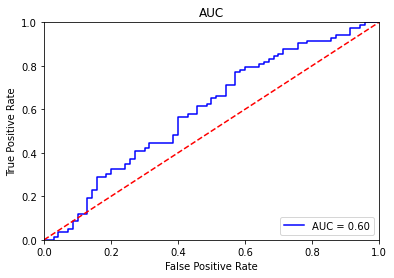

In [ ]:
import matplotlib.pyplot as plt
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

In [ ]:

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Model training and saving best model

best_accuracy=0.0


for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model_ft.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer_ft.zero_grad()
        
        outputs= model_ft(images)
        loss=criterion(outputs,labels)
        
        loss.backward()
        optimizer_ft.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model_ft.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model_ft(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model_ft.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    



Epoch: 0 Train Loss: tensor(0.5950) Train Accuracy: 0.7119341563786008 Test Accuracy: 0.6143790849673203
Epoch: 1 Train Loss: tensor(0.5758) Train Accuracy: 0.7283950617283951 Test Accuracy: 0.6797385620915033
Epoch: 2 Train Loss: tensor(0.6281) Train Accuracy: 0.6831275720164609 Test Accuracy: 0.6535947712418301
Epoch: 3 Train Loss: tensor(0.6141) Train Accuracy: 0.6748971193415638 Test Accuracy: 0.6666666666666666
Epoch: 4 Train Loss: tensor(0.6047) Train Accuracy: 0.7119341563786008 Test Accuracy: 0.6405228758169934
Epoch: 5 Train Loss: tensor(0.5824) Train Accuracy: 0.6954732510288066 Test Accuracy: 0.6601307189542484
Epoch: 6 Train Loss: tensor(0.6056) Train Accuracy: 0.7160493827160493 Test Accuracy: 0.6209150326797386
Epoch: 7 Train Loss: tensor(0.5593) Train Accuracy: 0.7325102880658436 Test Accuracy: 0.6209150326797386
Epoch: 8 Train Loss: tensor(0.6221) Train Accuracy: 0.6790123456790124 Test Accuracy: 0.6535947712418301
Epoch: 9 Train Loss: tensor(0.5449) Train Accuracy: 0.7